In [138]:
from pyspark.sql import SparkSession
import pyspark.sql
from pyspark.sql.functions import col
import warnings
warnings.filterwarnings("ignore")
from pyspark.sql.types import *
import datetime
import pandas as pd

# Create a spark session (which will run spark jobs)
spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.execution.arrow.pyspark.enabled', True)
spark.sparkContext.setLogLevel("OFF")

### Reading in the Data
taxi_type = "yellow"
data_dir = 'data/' + taxi_type + '*'
sdf = spark.read.csv(data_dir, header=True)
f"{sdf.count():,} rows!"

### Code below created by modifying code by Akira Takihara Wang
### https://github.com/akiratwang/MAST30034_Python/blob/main/advanced_tutorials/Spark%20Tutorial.ipynb
def create_schema(data_dir):
    ints = ['VendorID', 'passenger_count', 'RateCodeID', 'RatecodeID','payment_type', 'PULocationID', 'DOLocationID']
    doubles = ['trip_distance','fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge']
    strings = ['store_and_fwd_flag']
    dtimes = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']
    
    if taxi_type == "green":
        doubles.append("ehail_fee")
        ints.append("trip_type")
        dtimes = ['lpep_pickup_datetime', 'lpep_dropoff_datetime']

    dtypes = {column: IntegerType() for column in ints}
    dtypes.update({column: DoubleType() for column in doubles})
    dtypes.update({column: StringType() for column in strings})
    dtypes.update({column: TimestampType() for column in dtimes})

    schema = StructType()

    for column in sdf.columns:
        schema.add(column, # column name
                   dtypes[column], # data type
                   True # is nullable?
                  )
    return schema

schema = create_schema(data_dir)
sdf = spark.read.csv(data_dir, header=True, schema=schema) \
    .withColumnRenamed("RatecodeID","RateCodeID") # rename the wrong column
# Renaming lpep columns to tpep, for consistency so that it worths with later cuntions
sdf = sdf.withColumnRenamed("lpep_pickup_datetime","tpep_pickup_datetime")
sdf = sdf.withColumnRenamed("lpep_dropoff_datetime","tpep_dropoff_datetime")

In [ ]:
### Data cleaning
# Removing entries not actually in 2020
sdf = sdf.filter((sdf.tpep_pickup_datetime >= datetime.datetime(2020,1,1,0,0,0)) & \
    (sdf.tpep_pickup_datetime < datetime.datetime(2021,1,1,0,0,0)))  
# Finding the min time, to verify it is infact the first day of 2020
time = sdf.select(pyspark.sql.functions.min("tpep_pickup_datetime")).collect()[0][0]
print(f"The first entry for a cab is at {time}")

In [ ]:
### Getting the proportions of cars that are hailed, vs ordered, vs NA
# Only applicable to green cab
nums = list(sdf.groupby("trip_type").count().collect()) # Getting counts of trip types
nums = list(map(lambda x: list(x)[1], nums))    # Flattening
nums = list(map(lambda x: x/sum(nums), nums))   # Converting to percentage of total
print(f"NULL: {nums[0]*100:.2f}%, Street Hail: {nums[1]*100:.2f}%, Dispath: {nums[2]*100:.2f}%")

In [ ]:
### Get the average number of pickups in a 10 minute interval in a given PU location ID
print(f"There are {sdf.count()} trips in total and {sdf.select('PULocationID').distinct().count()} \
    unique PULocationIDs.")
num = sdf.count()/sdf.select("PULocationID").distinct().count()/366/24/6
print(f"In a 10 minute interval in a given location ID there are on average {num:.2f} trips.")

# Getting the number of location IDs
num_locations = sdf.agg({'PULocationID': 'max'}).collect()[0][0]
temp_sdf_date = datetime.datetime(2020,1,1)
curr_pickup_time = datetime.datetime(2020,1,1,0,0,0)

In [ ]:
# This block is all about creating an animation to show the density of pickups at location ids over time
# Gets the number of pickups in the given time interval from the temporary sdf (temp_sdf)
def get_pickups(time_interval_in_seconds):
    global curr_pickup_time
    num_pickups = list([0]*num_locations)
    
    sdf_within_interval = temp_sdf.filter((temp_sdf.tpep_pickup_datetime >= curr_pickup_time) & \
        (temp_sdf.tpep_pickup_datetime < \
        curr_pickup_time + datetime.timedelta(seconds = time_interval_in_seconds)))
    counts = sdf_within_interval.groupby("PULocationID").count().collect()
    for count in counts:
        num_pickups[count[0]-1] = count[1]
    
    curr_pickup_time += datetime.timedelta(seconds = time_interval_in_seconds)
    if curr_pickup_time > temp_sdf_date:
        populate_temp_sdf()
    return num_pickups

# Creates a df with the next days event's, returns None if 2021 is reached.
# This is hard coded since the anaylsed data is from 2020
def populate_temp_sdf():
    global temp_sdf_date
    
    if temp_sdf_date == datetime.datetime(2021, 1, 1):
        return None
    
    temp_sdf = sdf.filter((sdf.tpep_pickup_datetime >= temp_sdf_date) & \
        (sdf.tpep_pickup_datetime < temp_sdf_date + datetime.timedelta(days=1)))
    temp_sdf.cache()
    
    temp_sdf_date += datetime.timedelta(days=1)
    
    return temp_sdf

temp_sdf = populate_temp_sdf()

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import matplotlib.animation as animation
fig = plt.figure()
#creating a subplot 
ax1 = fig.add_subplot(1,1,1)
def animate(i):
    ax1.clear()
    
    plt.title(f'Pick Up Density over Time - {curr_pickup_time}')
    plt.xlabel('Location IDs')
    plt.ylabel('Number of Pickups')
    plt.ylim(top=100)
    
    locations = list(range(1, num_locations+1))
    num_pickups = get_pickups(60*10) # 10 minute interval
    ax1.bar(locations, num_pickups)
    
ani = animation.FuncAnimation(fig, animate, interval=250, frames=6*23) 
ani.save('sine_wave.gif', writer='imagemagick')

In [ ]:
### A small test of regression in spark
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
tiny_sdf = spark.read.csv("tmp.csv", header = True)
schema = StructType()
ints = ('MATH', 'CS', 'Score')
dtypes = {column: IntegerType() for column in ints}
schema = StructType()

for column in tiny_sdf.columns:
    schema.add(column, # column name
               dtypes[column], # data type
               True # is nullable?
              )

tiny_sdf = spark.read.csv("tmp.csv", header = True, schema=schema)

vectorAssembler = VectorAssembler(inputCols = ['MATH', 'CS'], outputCol = 'features')
tiny_sdf = vectorAssembler.transform(tiny_sdf)
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, labelCol='Score', featuresCol = 'features')
model = lr.fit(tiny_sdf)
tiny_sdf.show()
for i in range(4):
    model.predict(tiny_sdf.head(4)[i].features)

In [147]:
### Reducing sdf into a structure (sdf2) containing the day of the year (1-365), the day of the week (1-7)
###, the time_interval and the location ID for each taxi trip
def transform(x):
    time = x.tpep_pickup_datetime
    time_interval = 60*10 # 10 minute interval
    time_interval_index = ((time.hour*3600) + (time.minute*60) + (time.second))//time_interval
    return time.timetuple().tm_yday, time.weekday(), time_interval_index, x.PULocationID

from os import path
if path.isdir(f"Intervaled_{taxi_type}"):
    ### Reading an existing sdf2
    sdf2 = spark.read.csv(f"Intervaled_{taxi_type}", header=True)
    ints = ["day_of_year", "day_of_week", "time_interval", "PULocationID"]
    dtypes = {column: IntegerType() for column in ints}
    schema = StructType()
    [schema.add(column, dtypes[column], True) for column in sdf2.columns]
    sdf2 = spark.read.csv(f"Intervaled_{taxi_type}", header=True, schema = schema)
else:
    rdd2 = sdf.rdd.map(transform)
    sdf2 = rdd2.toDF(["day_of_year", "day_of_week", "time_interval","PULocationID"])
    sdf2.write.csv(f"Intervaled_{taxi_type}", header = True)
    sdf2.persist(pyspark.StorageLevel.DISK_ONLY)

sdf2.show(5)

+-----------+-----------+-------------+------------+
|day_of_year|day_of_week|time_interval|PULocationID|
+-----------+-----------+-------------+------------+
|        336|          1|            0|         138|
|        336|          1|            4|         140|
|        336|          1|            3|         132|
|        336|          1|            0|         238|
|        336|          1|            3|         238|
+-----------+-----------+-------------+------------+
only showing top 5 rows



In [179]:
### Aggregate sdf2 to get the number of trips \
### on a given day of the year, in a given time interval in a location -> sdf3
sdf3 = sdf2.groupby(["day_of_year", "day_of_week", "time_interval", "PULocationID"]).count()
sdf3 = sdf3.withColumnRenamed("count","counts")
sdf3.show(4)
print(sdf3.count())
sdf3.persist(pyspark.StorageLevel.DISK_ONLY)

+-----------+-----------+-------------+------------+------+
|day_of_year|day_of_week|time_interval|PULocationID|counts|
+-----------+-----------+-------------+------------+------+
|        336|          1|            1|         234|     1|
|        336|          1|            1|         236|     1|
|        336|          1|            6|         161|     1|
|        336|          1|           13|         132|     1|
+-----------+-----------+-------------+------------+------+
only showing top 4 rows

2930148


DataFrame[day_of_year: int, day_of_week: int, time_interval: int, PULocationID: int, counts: bigint]

In [180]:
### Adding 0 count values to keys where there were no trips, these do not otherwise show up

### Creating the list of every day_of_year and day_of_week in a manner that they're in sync
temp_sdf_date = datetime.datetime(2020,1,1)
days_of_year_and_week = []
while temp_sdf_date != datetime.datetime(2021, 1, 1):
    days_of_year_and_week.append((temp_sdf_date.timetuple().tm_yday, temp_sdf_date.weekday(), 0))
    temp_sdf_date += datetime.timedelta(days=1)

temp_sdf1 = spark.createDataFrame(data=days_of_year_and_week, schema = ["day_of_year", "day_of_week", "counts"])
temp_sdf2 = spark.range(1, num_locations+1).withColumnRenamed("id","PULocationID")
# Cross join to get every combiantion of location ID and day of year
temp_sdf3 = temp_sdf1.crossJoin(temp_sdf2)
num_time_intervals = int((24*60*60)/(60*10)) # Num of seconds in a day, divided by num of seconds in 10 minutes
temp_sdf4 = spark.range(0, num_time_intervals).withColumnRenamed("id","time_interval")
# Cross join to get every combiantion of location ID and day of year and time_interval
temp_sdf5 = temp_sdf3.crossJoin(temp_sdf4)
temp_sdf5.show(5)
print(temp_sdf5.count())
print(sdf3.count())

# Removing rows in temp_sdf5 that are already in sdf3, so these are non zero counts
temp_sdf5 = temp_sdf5.join(sdf3, [sdf3.day_of_year == temp_sdf5.day_of_year,\
                            sdf3.time_interval == temp_sdf5.time_interval,\
                            sdf3.PULocationID == temp_sdf5.PULocationID],"leftanti")
temp_sdf5.show(5)
print(temp_sdf5.count())

# Now union temp_sdf5 with sdf3 to get those zero counts back into sdf3
sdf3 = sdf3.union(temp_sdf5)
sdf3.show(5)
sdf3.persist(pyspark.StorageLevel.DISK_ONLY)
print(sdf3.count())


+-----------+-----------+------+------------+-------------+
|day_of_year|day_of_week|counts|PULocationID|time_interval|
+-----------+-----------+------+------------+-------------+
|          1|          2|     0|           1|            0|
|          1|          2|     0|           1|            1|
|          1|          2|     0|           1|            2|
|          1|          2|     0|           1|            3|
|          1|          2|     0|           1|            4|
+-----------+-----------+------+------------+-------------+
only showing top 5 rows

13966560
2930148


+-----------+-----------+------+------------+-------------+
|day_of_year|day_of_week|counts|PULocationID|time_interval|
+-----------+-----------+------+------------+-------------+
|          1|          2|     0|          78|            0|
|          1|          2|     0|          56|            1|
|          1|          2|     0|           3|            2|
|          1|          2|     0|          59|            2|
|          1|          2|     0|         195|            5|
+-----------+-----------+------+------------+-------------+
only showing top 5 rows



11036412


+-----------+-----------+-------------+------------+------+
|day_of_year|day_of_week|time_interval|PULocationID|counts|
+-----------+-----------+-------------+------------+------+
|        336|          1|            1|         234|     1|
|        336|          1|            1|         236|     1|
|        336|          1|            6|         161|     1|
|        336|          1|           13|         132|     1|
|        336|          1|           47|         162|     8|
+-----------+-----------+-------------+------------+------+
only showing top 5 rows



13966560


In [557]:
### One Hot Encoding the attributes of intesrest, day_of_week, time_interval, PULocationID -> sdf4
### Then performing simple linear regression on a 70 30 split.
from pyspark.ml.feature import VectorAssembler, OneHotEncoder
from pyspark.ml.regression import LinearRegression

sdf4 = OneHotEncoder(inputCols = ["day_of_week","time_interval","PULocationID"], \
                     outputCols = ["day_of_week_vec","time_interval_vec","PULocationID_vec"]).fit(sdf3).transform(sdf3)
sdf4.show(5)
vectorAssembler = VectorAssembler(inputCols = ["day_of_week_vec","time_interval_vec","PULocationID_vec"], \
                                  outputCol = 'features')
sdf4 = vectorAssembler.transform(sdf4)
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, labelCol='counts', featuresCol = 'features')

splits = sdf4.randomSplit([0.7, 0.3])
train_sdf4 = splits[0]
test_sdf4 = splits[1]
                 
lr_model = lr.fit(train_sdf4)

+-----------+-----------+-------------+------------+------+---------------+-----------------+-----------------+
|day_of_year|day_of_week|time_interval|PULocationID|counts|day_of_week_vec|time_interval_vec| PULocationID_vec|
+-----------+-----------+-------------+------------+------+---------------+-----------------+-----------------+
|        336|          1|            1|         234|     1|  (6,[1],[1.0])|  (143,[1],[1.0])|(265,[234],[1.0])|
|        336|          1|            1|         236|     1|  (6,[1],[1.0])|  (143,[1],[1.0])|(265,[236],[1.0])|
|        336|          1|            6|         161|     1|  (6,[1],[1.0])|  (143,[6],[1.0])|(265,[161],[1.0])|
|        336|          1|           13|         132|     1|  (6,[1],[1.0])| (143,[13],[1.0])|(265,[132],[1.0])|
|        336|          1|           47|         162|     8|  (6,[1],[1.0])| (143,[47],[1.0])|(265,[162],[1.0])|
+-----------+-----------+-------------+------------+------+---------------+-----------------+-----------

In [560]:
### Evaluate the linear regression model
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)
lr_model.evaluate(train_sdf4)

from pyspark.ml.evaluation import RegressionEvaluator
lr_predictions = lr_model.transform(test_sdf4)
lr_predictions.select("prediction","counts","features").show(5)
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="counts",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="counts",metricName="rmse")
print("RMSE on test data = %g" % lr_evaluator.evaluate(lr_predictions))

RMSE: 38.404506
r2: 0.297444


+------------------+------+--------------------+
|        prediction|counts|            features|
+------------------+------+--------------------+
| 8.563245106624027|    55|(414,[2,13,380],[...|
|12.852994098573195|   101|(414,[2,14,386],[...|
| 7.286250220900919|    49|(414,[2,18,286],[...|
|3.9601540968445432|    10|(414,[2,20,223],[...|
| 7.302405577989433|    12|(414,[2,35,263],[...|
+------------------+------+--------------------+
only showing top 5 rows



R Squared (R2) on test data = 0.297497


RMSE on test data = 38.4029


In [ ]:
### Taken from 
### https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/1779476228152266/1437143569842658/5673666086694627/latest.html

# evaluate RMSE
from math import sqrt
def calcRMSE(df, labelCol='label'):
  """Given a DataFrame with 'label' and 'prediction' columns, calculate the root-mean-squared error
    Args:
        df: a DataFrame with labels and predictions        
    Returns:
        Float
  """
  return sqrt(float(df
                     .rdd
                     .map(lambda row: (row[labelCol]-row['prediction'])**2)
                     .reduce(lambda a,b: a+b)
                    ) / df.count() )

# evaluate R-squared
def calcRsq(df, labelCol='label'):
  """Given a DataFrame with 'label' and 'prediction' columns, calculate the R-squared diagnostic  
    Args:
        df: a DataFrame with labels and predictions        
    Returns:
        Float
  """
  npts = df.count()
  mean_label = float(df.rdd.map(lambda row: row[labelCol]).reduce(lambda a,b: a+b))/npts
  total_squared_error = (df
                        .rdd
                        .map(lambda row: (row[labelCol]-mean_label)**2)
                        .reduce(lambda a,b: a+b)
                        )
  squared_error = (df
                   .rdd
                   .map(lambda row: (row[labelCol]-row['prediction'])**2)
                   .reduce(lambda a,b: a+b)
                  )  
  return (1.0 - float(squared_error) / total_squared_error)

In [193]:
### Aggregate sdf2 to get the number of trips \
### on a given day of the week, in a given time interval in a location -> sdf3
### This will form the basis for the BASELINE MODEL which is simply the average of the number of trips
### on a day of the week, in a time interval, in a location ID
sdf5 = sdf2.groupby(["day_of_week", "time_interval", "PULocationID"]).count()
sdf5 = sdf5.withColumnRenamed("count","counts")
sdf5.show(4)

### Adding zero values to sdf5. This is a certain day, location and time interval that has so trips across the
### whole year
temp_sdf1 = spark.createDataFrame(data=list(zip(range(7), [0]*7)), schema = ["day_of_week", "counts"])
temp_sdf2 = spark.range(1, num_locations+1).withColumnRenamed("id","PULocationID")
# Cross join to get every combination of location ID and day of week
temp_sdf3 = temp_sdf1.crossJoin(temp_sdf2)
num_time_intervals = int((24*60*60)/(60*10)) # Num of seconds in a day, divided by num of seconds in 10 minutes
temp_sdf4 = spark.range(0, num_time_intervals).withColumnRenamed("id","time_interval")
# Cross join to get every combiantion of location ID and day of week and time_interval
temp_sdf5 = temp_sdf3.crossJoin(temp_sdf4)

# Removing rows in temp_sdf5 that are already in sdf5, so these are non zero counts
temp_sdf5 = temp_sdf5.join(sdf5, [sdf5.day_of_week == temp_sdf5.day_of_week,\
                            sdf5.time_interval == temp_sdf5.time_interval,\
                            sdf5.PULocationID == temp_sdf5.PULocationID],"leftanti")
# Now union temp_sdf5 with sdf5 to get those zero counts back into sdf5
sdf5 = sdf5.union(temp_sdf5)
sdf5.show(5)

### Perform averaging
def transform(x):
    return x.day_of_week, x.time_interval, x.PULocationID, (x.counts/(366/7))
rdd5 = sdf5.rdd.map(transform)
sdf5 = rdd5.toDF(["day_of_week", "time_interval","PULocationID", "counts"])
sdf5.show(4)
sdf5.persist(pyspark.StorageLevel.DISK_ONLY)

sdf5.agg({'counts': 'max'}).show()

+-----------+-------------+------------+------+
|day_of_week|time_interval|PULocationID|counts|
+-----------+-------------+------------+------+
|          1|            4|         263|    82|
|          1|           41|         223|    15|
|          1|           55|         107|   844|
|          1|           72|          42|    91|
+-----------+-------------+------------+------+
only showing top 4 rows



+-----------+-------------+------------+------+
|day_of_week|time_interval|PULocationID|counts|
+-----------+-------------+------------+------+
|          1|            4|         263|    82|
|          1|           41|         223|    15|
|          1|           55|         107|   844|
|          1|           72|          42|    91|
|          1|           71|         144|   175|
+-----------+-------------+------------+------+
only showing top 5 rows



+-----------+-------------+------------+-------------------+
|day_of_week|time_interval|PULocationID|             counts|
+-----------+-------------+------------+-------------------+
|          1|            4|         263| 1.5683060109289617|
|          1|           41|         223|0.28688524590163933|
|          1|           55|         107|  16.14207650273224|
|          1|           72|          42| 1.7404371584699454|
+-----------+-------------+------------+-------------------+
only showing top 4 rows



+-----------------+
|      max(counts)|
+-----------------+
|55.77049180327869|
+-----------------+



In [194]:
### join sdf3 with sdf5 to have the predictions and labels in the same DF -> sdf6
sdf_temp = sdf5.withColumnRenamed("counts","prediction")
sdf6 = (sdf3.join(sdf_temp, [sdf3.day_of_week == sdf_temp.day_of_week,\
                sdf3.time_interval == sdf_temp.time_interval,\
                sdf3.PULocationID == sdf_temp.PULocationID],"left"))\
                .select(sdf_temp["prediction"],sdf3["*"])
sdf6.show()

+-------------------+-----------+-----------+-------------+------------+------+
|         prediction|day_of_year|day_of_week|time_interval|PULocationID|counts|
+-------------------+-----------+-----------+-------------+------------+------+
|  4.226775956284153|        336|          1|            1|         234|     1|
| 1.7595628415300546|        336|          1|            1|         236|     1|
| 3.1748633879781423|        336|          1|            6|         161|     1|
| 1.1666666666666667|        336|          1|           13|         132|     1|
| 15.491803278688526|        336|          1|           47|         162|     8|
|0.13387978142076504|        336|          1|           49|         242|     1|
|   8.62568306010929|        336|          1|           59|         249|     6|
|   9.96448087431694|        336|          1|           57|          79|     8|
| 20.598360655737704|        336|          1|           57|         140|    22|
|  20.65573770491803|        336|       

In [195]:
print("Below are the metrics for the baseline model which consists of taking averages for each attribute combination")
print(f"RMSE is {calcRMSE(sdf6, labelCol='counts')}")
print(f"R2 is {calcRsq(sdf6, labelCol='counts')}")

RMSE is 81.36594632015633


R2 is -2.7731334406272805


In [267]:
### The blocks below investigate attribute interaction
### One hot encode the attribtues of interest.
### The previous one hot encoded data can't be used since it was aggregated over these attributes og interest
### And the purpose of the correlation is to see patterns in how often some of these attributes occur together
sdf6 = OneHotEncoder(inputCols = ["day_of_week","time_interval","PULocationID"], \
                     outputCols = ["day_of_week_vec","time_interval_vec","PULocationID_vec"]).fit(sdf2).transform(sdf2)
sdf6.show(5)

### Combinging the one hot encodes into a single vector
vectorAssembler = VectorAssembler(inputCols = ["day_of_week_vec","time_interval_vec","PULocationID_vec"], \
                                  outputCol = 'features')
sdf6 = vectorAssembler.transform(sdf6)
sdf6.show(5)

from pyspark.ml.stat import Correlation
pearsonCorr = Correlation.corr(sdf6, 'features', 'pearson').collect()[0][0]

+-----------+-----------+-------------+------------+---------------+-----------------+-----------------+
|day_of_year|day_of_week|time_interval|PULocationID|day_of_week_vec|time_interval_vec| PULocationID_vec|
+-----------+-----------+-------------+------------+---------------+-----------------+-----------------+
|        336|          1|            0|         138|  (6,[1],[1.0])|  (143,[0],[1.0])|(265,[138],[1.0])|
|        336|          1|            4|         140|  (6,[1],[1.0])|  (143,[4],[1.0])|(265,[140],[1.0])|
|        336|          1|            3|         132|  (6,[1],[1.0])|  (143,[3],[1.0])|(265,[132],[1.0])|
|        336|          1|            0|         238|  (6,[1],[1.0])|  (143,[0],[1.0])|(265,[238],[1.0])|
|        336|          1|            3|         238|  (6,[1],[1.0])|  (143,[3],[1.0])|(265,[238],[1.0])|
+-----------+-----------+-------------+------------+---------------+-----------------+-----------------+
only showing top 5 rows

+-----------+-----------+-----

There are 0 nan values in the correlation matrix.
The matrix has a shape of (414, 414)
The max and min correlation are 0.038152995882999585 and -0.19133745245591496


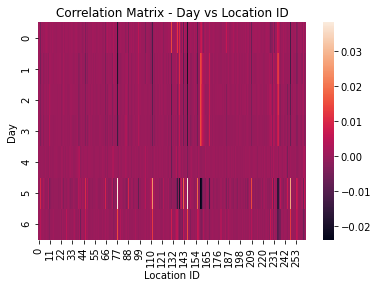

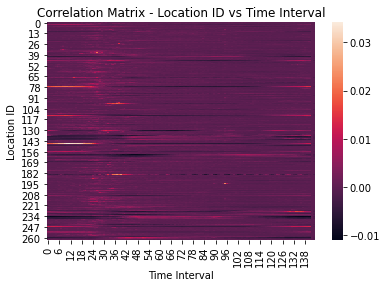

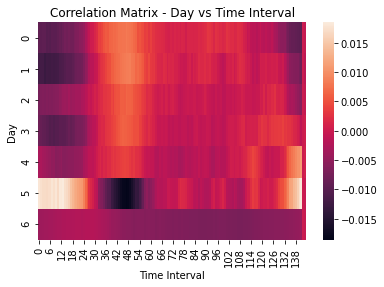

In [542]:
import numpy as np
arr = pearsonCorr.toArray()
print(f"There are {np.sum(np.isnan(pearsonCorr.toArray()))} nan values in the correlation matrix.")
print(f"The matrix has a shape of {arr.shape}")
np.nan_to_num(arr, copy=False, nan=0.0)
print(f"The max and min correlation are {np.max(arr)} and {np.min(arr)}")

import seaborn as sns
# Changing the diagonal elements to 0
for i in range(len(arr)):
    arr[i][i] = 0

# Plot the Day vs Location
sns_plot = sns.heatmap(arr[:7, 7+144:])
sns_plot.set(xlabel="Location ID", ylabel = "Day")
sns_plot.set_title("Correlation Matrix - Day vs Location ID")
sns_plot.figure.savefig('plots/Day vs Location ID.png',dpi=600)
plt.show()

# Plot the Location vs Time
sns_plot = sns.heatmap(arr[7+144:,7:7+144])
sns_plot.set(xlabel="Time Interval", ylabel = "Location ID")
sns_plot.set_title("Correlation Matrix - Location ID vs Time Interval")
sns_plot.figure.savefig('plots/Location ID vs Time Interval.png',dpi=600)
plt.show()

# Plot the Day vs Time
sns_plot = sns.heatmap(arr[:7,7:7+144])
sns_plot.set(xlabel="Time Interval", ylabel = "Day")
sns_plot.set_title("Correlation Matrix - Day vs Time Interval")
sns_plot.figure.savefig('plots/Day vs Time Interval.png',dpi=600)
plt.show()

In [555]:
### Reading in and interpolating temperature data
import pandas as pd
df = pd.read_csv("NOAA/72505394728.csv")
df = df[["DATE", "HourlyDryBulbTemperature"]]
df = df.dropna()
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.drop_duplicates(subset = ["DATE"])

# Function to convert to minutes since the start of 2020
def f(x):
    minutes_in_day = 24*60
    minutes_in_hour = 60
    return ((x.timetuple().tm_yday-1) * minutes_in_day) + (x.hour * minutes_in_hour) + x.minute
df["DATE"] = df["DATE"].apply(f)

# Filter out all characters from the temperature column
import re
def f(x):
    if isinstance(x, str):
        return re.sub('\D', '', x)
    return x
df["HourlyDryBulbTemperature"] = df["HourlyDryBulbTemperature"].apply(f)

# DF2 that contains all minutes for the whole year
df2 = pd.DataFrame(range(366*24*60), columns = ["DATE"])
df = df.merge(df2, on="DATE", how="right")
# Replace the first row of the new df that contains all minutes for the whole year with the first acutal
# temperature value, which in this case is 40F. This is to assist with interpolation
df.loc[df['DATE'] == 0, ['HourlyDryBulbTemperature']] = df.dropna()['HourlyDryBulbTemperature'].iloc[0]

# Convert to float and interpolate
df["HourlyDryBulbTemperature"] = df["HourlyDryBulbTemperature"].astype(float).interpolate()

# Since we're working with 10 minute intervals, drop everything that's not a multiple of 10
df = df[df["DATE"]%10 == 0]
# Convert the Date ID back to datetime
OG_date = datetime.datetime(2020,1,1)
def f(x):
    return OG_date + datetime.timedelta(minutes=x)
df["actual_date"] = df["DATE"].apply(f)

# Convert the actual date into day_of_week, day_of_year, and time_interval
def transform(time):
    time_interval = 60*10 # 10 minute interval
    time_interval_index = ((time.hour*3600) + (time.minute*60) + (time.second))//time_interval
    return time.timetuple().tm_yday, time.weekday(), time_interval_index

sdf_dates_df = pd.DataFrame(df["actual_date"].apply(transform).tolist(), \
                            columns=["day_of_year", "day_of_week", "time_interval"])
df = pd.concat([df.reset_index(), sdf_dates_df.reset_index()], axis=1)
df = df.drop(columns = ["index", "DATE", "actual_date", "index"])

### Join the temperature data with sdf3
sdf7 = spark.createDataFrame(df)
sdf7 = sdf4.join(sdf7, ["day_of_year", "day_of_week", "time_interval"])

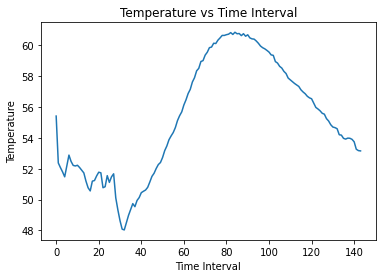

In [517]:
### Temperature vs Time Interval
nums = sdf7.groupby(["time_interval"]).agg({'HourlyDryBulbTemperature': 'avg'}).collect()
nums = sorted(nums, key = lambda x: x["time_interval"])
intervals, temps = list(zip(*nums))
plt.plot(intervals, temps)
plt.title('Temperature vs Time Interval')
plt.xlabel('Time Interval')
plt.ylabel('Temperature')
plt.savefig('plots/Temperature vs Time Interval.png')
plt.show()



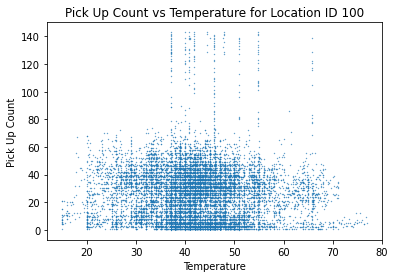

In [553]:
### Pick Up count vs Temperature for Location ID 100
data = sdf7.filter((sdf7.PULocationID == 100)&(sdf7.day_of_year < 90)) \
    .select(["counts", "HourlyDryBulbTemperature"]).collect()
counts, temps = list(zip(*data))
plt.scatter(temps,counts,s=0.1)
plt.title('Pick Up Count vs Temperature for Location ID 100')
plt.ylabel('Pick Up Count')
plt.xlabel('Temperature')
plt.savefig('plots/Pick Up Count vs Temperature for Location ID 100 (3 months).png')
plt.show()


In [561]:
### Decision tree regression with temperature
from pyspark.ml.regression import DecisionTreeRegressor
dtr = DecisionTreeRegressor(labelCol='counts', featuresCol = 'features')

splits = sdf7.randomSplit([0.7, 0.3])
train_sdf7 = splits[0]
test_sdf7 = splits[1]
                 
dtr_model = dtr.fit(train_sdf7)

### Evaluate the Decision tree regression model
from pyspark.ml.evaluation import RegressionEvaluator
### Training Data
dtr_predictions = dtr_model.transform(train_sdf7)
dtr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="counts",metricName="r2")
print("R Squared (R2) on train data = %g" % dtr_evaluator.evaluate(dtr_predictions))
dtr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="counts",metricName="rmse")
print("RMSE on train data = %g" % dtr_evaluator.evaluate(dtr_predictions))

### Test Data
dtr_predictions = dtr_model.transform(test_sdf7)
dtr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="counts",metricName="r2")
print("R Squared (R2) on test data = %g" % dtr_evaluator.evaluate(dtr_predictions))
dtr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="counts",metricName="rmse")
print("RMSE on test data = %g" % dtr_evaluator.evaluate(dtr_predictions))


+------------------+------+--------------------+
|        prediction|counts|            features|
+------------------+------+--------------------+
|7.4739932200780155|     9|(414,[2,9,153],[1...|
|7.4739932200780155|     1|(414,[2,9,159],[1...|
|7.4739932200780155|    13|(414,[2,9,162],[1...|
|7.4739932200780155|     1|(414,[2,9,164],[1...|
|7.4739932200780155|     2|(414,[2,9,166],[1...|
+------------------+------+--------------------+
only showing top 5 rows



R Squared (R2) on train data = 0.298522


RMSE on train data = 38.3729


+------------------+------+--------------------+
|        prediction|counts|            features|
+------------------+------+--------------------+
|7.4739932200780155|     1|(414,[2,9,152],[1...|
|7.4739932200780155|     5|(414,[2,9,156],[1...|
|7.4739932200780155|     1|(414,[2,9,167],[1...|
|7.4739932200780155|     1|(414,[2,9,185],[1...|
|7.4739932200780155|     5|(414,[2,9,194],[1...|
+------------------+------+--------------------+
only showing top 5 rows



R Squared (R2) on test data = 0.298332


RMSE on test data = 38.385


In [562]:
### Decision tree regression with temperature
from pyspark.ml.regression import RandomForestRegressor
rfr = RandomForestRegressor(labelCol='counts', featuresCol = 'features')

splits = sdf7.randomSplit([0.7, 0.3])
train_sdf7 = splits[0]
test_sdf7 = splits[1]
                 
rfr_model = rfr.fit(train_sdf7)

### Evaluate the Decision tree regression model
from pyspark.ml.evaluation import RegressionEvaluator
### Training Data
rfr_predictions = rfr_model.transform(train_sdf7)
rfr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="counts",metricName="r2")
print("R Squared (R2) on train data = %g" % rfr_evaluator.evaluate(rfr_predictions))
rfr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="counts",metricName="rmse")
print("RMSE on train data = %g" % rfr_evaluator.evaluate(rfr_predictions))

### Test Data
rfr_predictions = rfr_model.transform(test_sdf7)
rfr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="counts",metricName="r2")
print("R Squared (R2) on test data = %g" % rfr_evaluator.evaluate(rfr_predictions))
rfr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="counts",metricName="rmse")
print("RMSE on test data = %g" % rfr_evaluator.evaluate(rfr_predictions))


R Squared (R2) on train data = 0.296375


RMSE on train data = 38.4362


R Squared (R2) on test data = 0.295677


RMSE on test data = 38.4469
